In [1]:
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
import numpy as np
import os

from collections import deque
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, RepeatVector, LSTM, Dense, Lambda, TimeDistributed
from tensorflow.keras import losses, metrics, activations
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import seaborn as sns

In [2]:
split = pickle.load(open('./final_data_ST_120_2019.pkl', 'rb'))['ST4000DM000']
file_list = os.listdir('./ST4000DM000')
train_list = split['train']
val_list = split['val']
test_list = split['test']
col = ['smart_7_raw', 'smart_9_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw', 'until_fail_days']
timestep_list = [5, 10, 20, 30]

In [3]:
scaler_path = './std_scaler.pkl'
scaler_zip = {f'{file_name[:-4]}':{} for file_name in file_list}
if not os.path.isfile(scaler_path):
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))
        for db_type in [30, 60, 120]:
            temp = db[db['until_fail_days']>db_type][col[:-1]]
            if len(temp) != 0:
                scaler = StandardScaler()
                scaler.fit(temp)
                scaler_zip[f'{file_name[:-4]}'][f'{db_type}'] = scaler
    
    pickle.dump(scaler_zip, open(scaler_path, 'wb'))
else:
    scaler_zip = pickle.load(open(scaler_path, 'rb'))

In [4]:
db_path = './STD_DB/db_120.pkl'
if not os.path.isfile(db_path):
    db_zip_120 = {f'{t}': {'train':[], 'val':[], 'test':[]} for t in timestep_list}
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))
        db = db[db['until_fail_days']>120][col[:-1]]
        for t in timestep_list:
            if len(db) >= t:
                scaled_db = scaler_zip[f'{file_name[:-4]}']['120'].transform(db)
                if file_name[:-4] in train_list:
                    db_zip_120[f'{t}']['train'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in val_list:
                    db_zip_120[f'{t}']['val'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in test_list:
                    db_zip_120[f'{t}']['test'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                    
    for t in timestep_list:
        db_zip_120[f'{t}']['train'] = np.concatenate(db_zip_120[f'{t}']['train'])
        db_zip_120[f'{t}']['val'] = np.concatenate(db_zip_120[f'{t}']['val'])
        db_zip_120[f'{t}']['test'] = np.concatenate(db_zip_120[f'{t}']['test'])
    pickle.dump(db_zip_120, open(db_path, 'wb'))
else:
    db_zip_120 = pickle.load(open(db_path, 'rb'))

In [5]:
db_path = './STD_DB/db_60.pkl'
if not os.path.isfile(db_path):
    db_zip_60 = {f'{t}': {'train':[], 'val':[], 'test':[]} for t in timestep_list}
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))
        db = db[db['until_fail_days']>60][col[:-1]]
        for t in timestep_list:
            if len(db) >= t:
                scaled_db = scaler_zip[f'{file_name[:-4]}']['60'].transform(db)
                if file_name[:-4] in train_list:
                    db_zip_60[f'{t}']['train'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in val_list:
                    db_zip_60[f'{t}']['val'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in test_list:
                    db_zip_60[f'{t}']['test'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                    
    for t in timestep_list:
        db_zip_60[f'{t}']['train'] = np.concatenate(db_zip_60[f'{t}']['train'])
        db_zip_60[f'{t}']['val'] = np.concatenate(db_zip_60[f'{t}']['val'])
        db_zip_60[f'{t}']['test'] = np.concatenate(db_zip_60[f'{t}']['test'])
    pickle.dump(db_zip_60, open(db_path, 'wb'))
else:
    db_zip_60 = pickle.load(open(db_path, 'rb'))

In [6]:
db_path = './STD_DB/db_30.pkl'
if not os.path.isfile(db_path):
    db_zip_30 = {f'{t}': {'train':[], 'val':[], 'test':[]} for t in timestep_list}
    for file_name in file_list:
        db = pickle.load(open(f'./ST4000DM000/{file_name}', 'rb'))
        db = db[db['until_fail_days']>30][col[:-1]]
        for t in timestep_list:
            if len(db) >= t:
                scaled_db = scaler_zip[f'{file_name[:-4]}']['30'].transform(db)
                if file_name[:-4] in train_list:
                    db_zip_30[f'{t}']['train'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in val_list:
                    db_zip_30[f'{t}']['val'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                elif file_name[:-4] in test_list:
                    db_zip_30[f'{t}']['test'].append([scaled_db[line:line+t] for line in range(0, len(scaled_db)-t+1)])
                    
    for t in timestep_list:
        db_zip_30[f'{t}']['train'] = np.concatenate(db_zip_30[f'{t}']['train'])
        db_zip_30[f'{t}']['val'] = np.concatenate(db_zip_30[f'{t}']['val'])
        db_zip_30[f'{t}']['test'] = np.concatenate(db_zip_30[f'{t}']['test'])
    pickle.dump(db_zip_30, open(db_path, 'wb'))
else:
    db_zip_30 = pickle.load(open(db_path, 'rb'))

In [7]:
def flatten(X):
    '''
    Flatten a 3D array.

    Input
    X            A 3D array for lstm, where the array is sample x timesteps x features.

    Output
    flattened_X  A 2D array, sample x features.
    '''
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1] - 1), :]
    return (flattened_X)

In [8]:
def lstm_ae(db, n_dimensions):
    time_step, input_dim = db.shape[1], db.shape[2]
    inputs = Input(shape=(time_step, input_dim))
    encoded = LSTM(n_dimensions, return_sequences=True, name="encoder_01")(inputs)
    encoded = LSTM(int(n_dimensions/2), return_sequences=False, name="encoder_02")(encoded)
    decoded = RepeatVector(time_step)(encoded)
    decoded = LSTM(int(input_dim/2), return_sequences=True, name='decoder_01')(decoded)
    decoded = LSTM(n_dimensions, return_sequences=True, name='decoder_02')(decoded)
    output = TimeDistributed(Dense(input_dim))(decoded)


    autoencoder = Model(inputs, output)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['cosine_proximity'])
    autoencoder.summary()
    return autoencoder

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 5)]           0         
                                                                 
 encoder_01 (LSTM)           (None, 20, 64)            17920     
                                                                 
 encoder_02 (LSTM)           (None, 32)                12416     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 20, 32)           0         
 or)                                                             
                                                                 
 decoder_01 (LSTM)           (None, 20, 2)             280       
                                                                 
 decoder_02 (LSTM)           (None, 20, 64)            17152     
                                                           

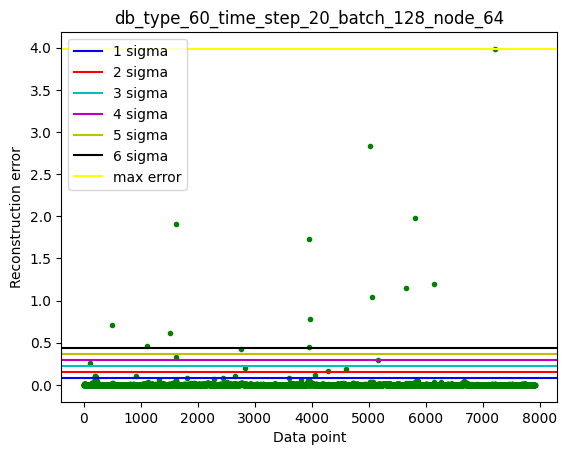

In [10]:
db_type = [60]
# db_type = [30]
epoch = 500
batch_size = 128
n_dimensions = 64

for temp in db_type:
    if temp == 60:
        db = db_zip_60
    elif temp == 120:
        db = db_zip_120
    elif temp == 30:
        db = db_zip_30
        
    for time_step in [20]:
        save_file_name = f'db_type_{temp}_time_step_{time_step}_batch_{batch_size}_node_{n_dimensions}.h5'
        db_path = f"./Model_STD/{save_file_name[:-3]}"
        if not os.path.exists(db_path):
            os.mkdir(db_path)

        callback = EarlyStopping(monitor='val_loss', patience=30, mode='min')
        mc = ModelCheckpoint(f'{db_path}/{save_file_name}', monitor='val_loss', mode='min', save_best_only=True)

        model = lstm_ae(db=db[f'{time_step}']['train'], n_dimensions=n_dimensions)
        history = model.fit(x=db[f'{time_step}']['train'], y=db[f'{time_step}']['train'], validation_data=(db[f'{time_step}']['val'], db[f'{time_step}']['val']), epochs=epoch, batch_size=batch_size, callbacks=[callback, mc])
        pickle.dump(history.history, open(f'{db_path}/history.pkl', 'wb'))
        
        
        threshold = {}
        train_pred = model.predict(db[f'{time_step}']['train'])
        mse = np.mean(np.power(flatten(db[f'{time_step}']['train']) - flatten(train_pred), 2), axis=1)
        error = pd.DataFrame({'reconstruction_error': mse, })
        temp_ = error.describe()
        for sigma in range(1,7,1):
            threshold[sigma] = (temp_.iloc[1].values) + (sigma * (temp_.iloc[2].values))
        threshold['max'] = max(mse)

        plt.plot(mse, 'g.')
        plt.axhline(threshold[1], color='b', label='1 sigma')
        plt.axhline(threshold[2], color='r', label='2 sigma')
        plt.axhline(threshold[3], color='c', label='3 sigma')
        plt.axhline(threshold[4], color='m', label='4 sigma')
        plt.axhline(threshold[5], color='y', label='5 sigma')
        plt.axhline(threshold[6], color='k', label='6 sigma')
        plt.axhline(threshold['max'], color='yellow', label='max error')

        plt.xlabel('Data point')
        plt.ylabel('Reconstruction error')
        plt.title(f'db_type_{temp}_time_step_{time_step}_batch_{batch_size}_node_{n_dimensions}')
        plt.legend()
        plt.savefig(f'{db_path}/db_type_{temp}_time_step_{time_step}_batch_{batch_size}_node_{n_dimensions}.png')
        pickle.dump(threshold, open(f'{db_path}/threshold.pkl', 'wb'))
        plt.show()

In [11]:
test_db_120 = {f'{t}': {'x':[], 'y':[]} for t in timestep_list}
for test_file_name in test_list:
    db = pickle.load(open(f'./ST4000DM000/{test_file_name}.pkl', 'rb'))
    scaled_db = scaler_zip[f'{test_file_name}']['120'].transform(db[col[:-1]])
    for t in timestep_list:
        for line in range(0, len(scaled_db)-t+1):
            test_db_120[f'{t}']['x'].append(scaled_db[line:line+t])
            if db.iloc[line+t-1]['until_fail_days'] > 120:
                test_db_120[f'{t}']['y'].append(0)
            else:
                test_db_120[f'{t}']['y'].append(1)

test_db_60 = {f'{t}': {'x':[], 'y':[]} for t in timestep_list}
for test_file_name in test_list:
    db = pickle.load(open(f'./ST4000DM000/{test_file_name}.pkl', 'rb'))
    scaled_db = scaler_zip[f'{test_file_name}']['60'].transform(db[col[:-1]])
    for t in timestep_list:
        for line in range(0, len(scaled_db)-t+1):
            test_db_60[f'{t}']['x'].append(scaled_db[line:line+t])
            if db.iloc[line+t-1]['until_fail_days'] > 60:
                test_db_60[f'{t}']['y'].append(0)
            else:
                test_db_60[f'{t}']['y'].append(1)
                
test_db_30 = {f'{t}': {'x':[], 'y':[]} for t in timestep_list}
for test_file_name in test_list:
    db = pickle.load(open(f'./ST4000DM000/{test_file_name}.pkl', 'rb'))
    scaled_db = scaler_zip[f'{test_file_name}']['30'].transform(db[col[:-1]])
    for t in timestep_list:
        for line in range(0, len(scaled_db)-t+1):
            test_db_30[f'{t}']['x'].append(scaled_db[line:line+t])
            if db.iloc[line+t-1]['until_fail_days'] > 30:
                test_db_30[f'{t}']['y'].append(0)
            else:
                test_db_30[f'{t}']['y'].append(1)

In [82]:
model_folder = os.listdir('./Model_STD')
result = {f'{num}':{} for num in range(len(model_folder))}
for num, folder in enumerate(model_folder):
    for i in os.listdir(f'./Model_STD/{folder}'):
        if i[-2:] == 'h5':
            model = tf.keras.models.load_model(f'./Model/{folder}/{i}')
            if folder.split('_')[2] == '60':
                db = test_db_60
            elif folder.split('_')[2] == '120':
                db = test_db_120
            elif folder.split('_')[2] == '30':
                db = test_db_30
            t = int(folder.split('_')[5])
            
            print(f'db_type: {folder.split("_")[2]}, time_step: {t}, node: {folder.split("_")[-1]}')
            print(f'Max_RE: {pickle.load(open(f"./Model_STD/{folder}/threshold.pkl", "rb"))["max"]}')
            
            test_pred = model.predict(np.array(db[f'{t}']['x']))
            mse = np.mean(np.power(flatten(np.array(db[f'{t}']['x'])) - flatten(test_pred), 2), axis=1)
            error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': db[f'{t}']['y']})
            
            normal_error_df = error_df[error_df['true_class']== 0]
            fraud_error_df = error_df[error_df['true_class'] == 1]
            
            fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
            roc_auc = auc(fpr, tpr)
            precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
            
            J = tpr - fpr
            ix = np.argmax(J)
            best_thresh = thresholds[ix]
            print(f"AUC: {roc_auc}")
            print(f"best_threshold: {best_thresh}")
            
            result[f'{num}']['db_type'] = folder.split("_")[2]
            result[f'{num}']['time_step'] = t
            result[f'{num}']['node'] = folder.split("_")[-1]
            result[f'{num}']['AUC'] = roc_auc
            result[f'{num}']['Max_RE'] = pickle.load(open(f"./Model_STD/{folder}/threshold.pkl", "rb"))["max"]
            result[f'{num}']['best_threshold'] = best_thresh

            # groups = error_df.groupby('true_class')
            # fig, ax = plt.subplots()

            # for name, group in groups:
            #     ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            #             label= "Failure" if name == 1 else "Normal")
            # ax.hlines(best_thresh, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
            # ax.legend()
            # plt.title("Reconstruction error for different classes")
            # plt.ylabel("Reconstruction error")
            # plt.xlabel("Data point index")
            # plt.show();
            
            # LABELS = ["Normal", "Failure"]
            # y_pred = [1 if e > best_thresh else 0 for e in error_df.reconstruction_error.values]
            # conf_matrix = confusion_matrix(error_df.true_class, y_pred)
            # plt.figure(figsize=(12, 12))
            # sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
            # plt.title("Confusion matrix")
            # plt.ylabel('True class')
            # plt.xlabel('Predicted class')
            # plt.show()
            
pd.DataFrame(result).T.to_excel('./result_STD__.xlsx')

db_type: 120, time_step: 10, node: 128
Max_RE: 0.6783752867112118
AUC: 0.9987968204501074
best_threshold: 2.1843443682786066
db_type: 120, time_step: 10, node: 256
Max_RE: 0.7380133329950129
AUC: 0.9977886918654981
best_threshold: 2.074404673889762
db_type: 120, time_step: 10, node: 32
Max_RE: 0.27259023073868827
AUC: 0.9986236853236202
best_threshold: 2.322784930952404
db_type: 120, time_step: 10, node: 64
Max_RE: 0.3267506140593407
AUC: 0.9977339022685084
best_threshold: 2.817417634146105
db_type: 120, time_step: 20, node: 128
Max_RE: 1.0603777430125159
AUC: 0.9977886839587115
best_threshold: 2.592707830590453
db_type: 120, time_step: 20, node: 256
Max_RE: 2.292721302475492
AUC: 0.9990913501357614
best_threshold: 2.0269425302744137
db_type: 120, time_step: 20, node: 32
Max_RE: 3.3275129460139667
AUC: 0.9994183568715641
best_threshold: 2.790824266430829
db_type: 120, time_step: 20, node: 64
Max_RE: 1.1657950560721047
AUC: 0.9986303242459412
best_threshold: 2.201549985858872
db_type: 1

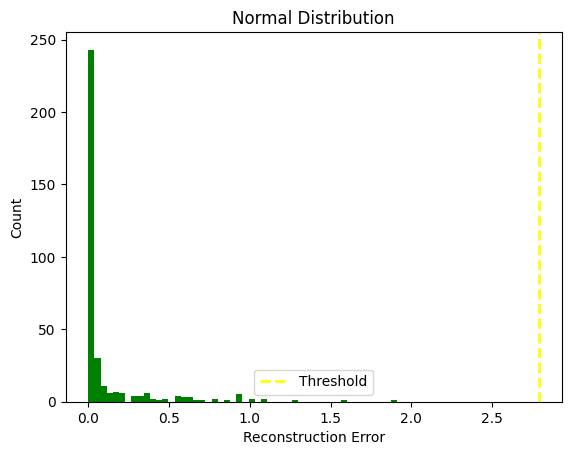

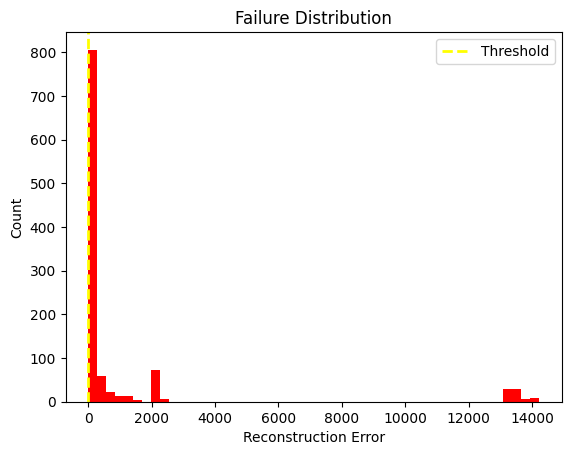

In [83]:
# test_db_type = [60, 120]

model = tf.keras.models.load_model('./Model_STD/db_type_120_time_step_20_batch_128_node_32/db_type_120_time_step_20_batch_128_node_32.h5')
best_thresh = 2.790824266430829
# for temp in test_db_type:
for temp in [120]:
    if temp == 60:
        db = test_db_60
    elif temp == 120:
        db = test_db_120
    elif temp == 30:
        db = test_db_30

    # for t in timestep_list:
    for t in [20]:
        test_pred = model.predict(np.array(db[f'{t}']['x']))
        mse = np.mean(np.power(flatten(np.array(db[f'{t}']['x'])) - flatten(test_pred), 2), axis=1)
        error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': db[f'{t}']['y']})
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        normal_error_df = error_df[error_df['true_class']== 0]
        _ = ax.hist(normal_error_df.reconstruction_error.values, bins=50, color='green')
        _ = ax.axvline(best_thresh, color='yellow', linestyle='--', linewidth=2, label='Threshold')
        # _ = ax.set_xlim(0, 0.00003)
        _ = ax.set_xlabel('Reconstruction Error')
        _ = ax.set_ylabel('Count')
        _ = ax.set_title('Normal Distribution')
        _ = ax.legend()
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        fraud_error_df = error_df[error_df['true_class'] == 1]
        _ = ax.hist(fraud_error_df.reconstruction_error.values, bins=50, color='red')
        _ = ax.axvline(best_thresh, color='yellow', linestyle='--', linewidth=2, label='Threshold')
        # _ = ax.set_xlim(best_thresh-4, best_thresh+3)
        _ = ax.set_xlabel('Reconstruction Error')
        _ = ax.set_ylabel('Count')
        _ = ax.set_title('Failure Distribution')
        _ = ax.legend()

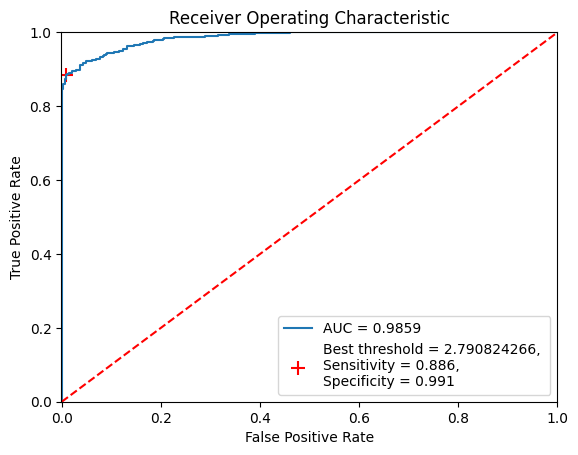

0.9858556184849938


In [75]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
J = tpr - fpr
ix = np.argmax(J)
sens, spec = tpr[ix], 1-fpr[ix]

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.scatter(fpr[ix], tpr[ix], marker='+', s=100, color='r', 
            label='Best threshold = %.9f, \nSensitivity = %.3f, \nSpecificity = %.3f' % (best_thresh, sens, spec))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();
print(roc_auc)

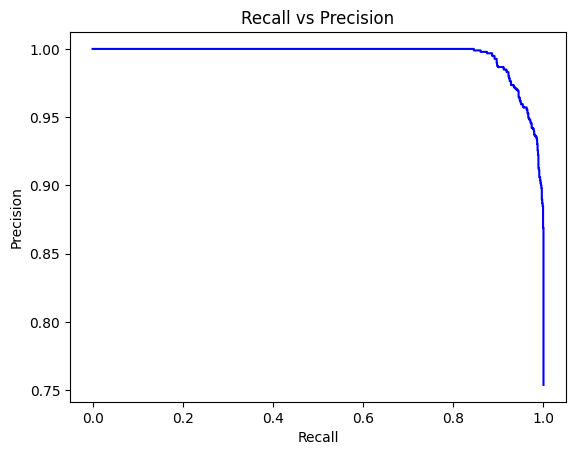

In [76]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

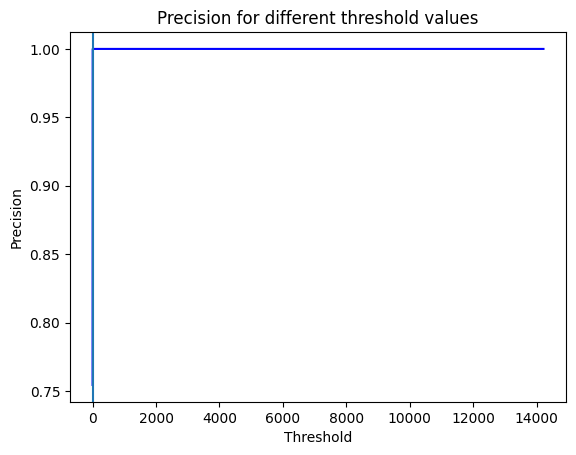

In [77]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.axvline(best_thresh)
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

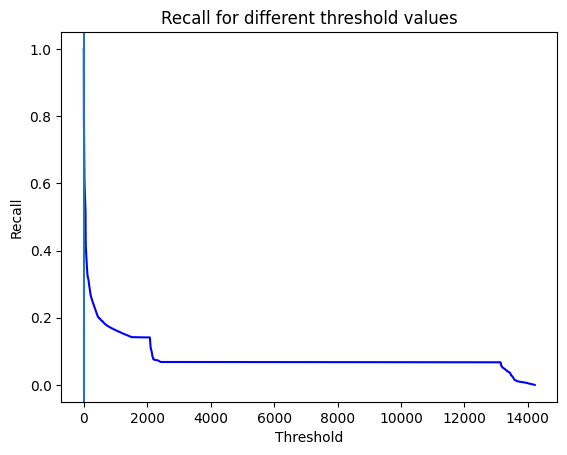

In [78]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.axvline(best_thresh)
plt.title('Recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

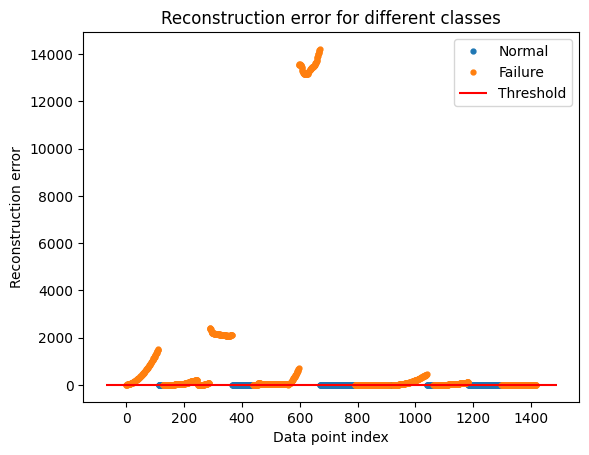

In [84]:
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Failure" if name == 1 else "Normal")
ax.hlines(best_thresh, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
# plt.ylim(0, best_thresh)
plt.show();

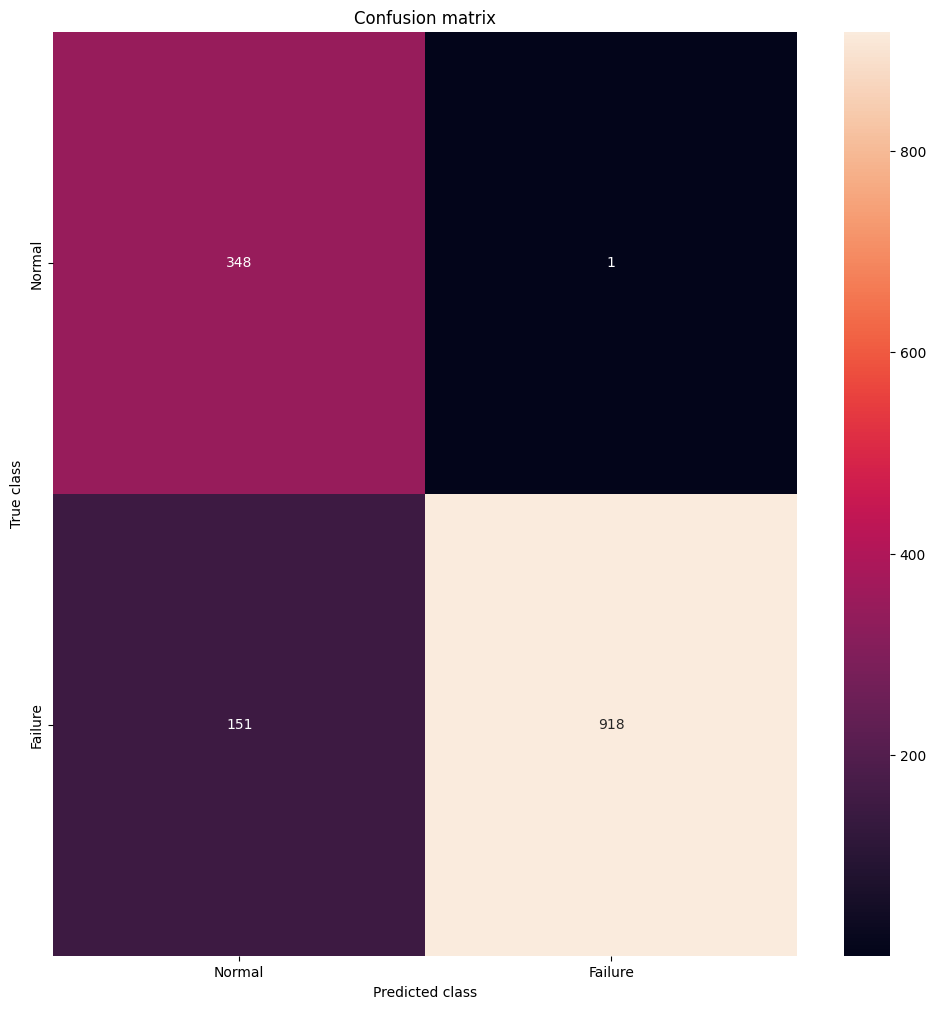

In [85]:
LABELS = ["Normal", "Failure"]
y_pred = [1 if e > best_thresh else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()